In [1]:
# !pip install loess
# !pip install csaps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import csaps
from patsy import cr
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib as mpl

Computing the Diagonal of the Smoother Matrix: Create a function to retrieve the diagonal of the smoother matrix. We’re only interested in the diagonal entries (which will be used in computing LOO-CV and GCV), so this function should return an n-by-1 vector.
Inputs: x (an n-by-1 feature vector) and span (a numerical value).
Output: n-by-1 vector representing the diagonal of the smoother matrix S.
Tip: Review the technique we used for the smoother matrix in smoothing spline models and adapt it for LOESS.

In [3]:
# read daraframe
df = pd.read_csv('Coding3_data.csv')

In [187]:
class myLoess(object):
    def __init__(self, x, y):
        min_v = np.min(x)
        max_v = np.max(x)
        self.x, self.min_x, self.max_x = (x - min_v)\
        / (max_v - min_v), min_v, max_v
#         min_v = np.min(yy)
#         max_v = np.max(yy)
        self.y, self.min_y, self.max_y = (y - min_v)\
        / (max_v - min_v), min_v, max_v
        

    def eval_est(self, x, W):
        xx = (x - self.min_x) /(self.max_x -self.min_x)
        a = np.abs(self.x - xx)
        rrange = self.dis_min(a, W)
        max_dist = np.max(a[rrange])
        a =a[rrange] / max_dist
        ww = np.zeros_like(a)
        idx = (a >= -1) & (a<= 1)
        ww[idx] = np.power(1.0 - np.power(np.abs(a[idx]), 3), 3)
        wo = np.ones((W, 1))
        wm = np.multiply(np.eye(W), ww)
        pp = np.array([[math.pow(xx, p)] for p in range(1)])
        ym = self.y[rrange]
        p = np.transpose(wo)@ wm
        j = np.linalg.pinv(p @ wo)@ p@ ym
        return (((j@ pp)[0]) * (self.max_y - self.min_y)) + self.min_y
    
    @staticmethod
    def dis_min(d, W):
        l = len(d)
        idx = np.argmin(d)
        if idx == 0:
            return np.arange(0, W)
        if idx == l-1:
            return np.arange(l - W, l)
        a = [idx]
        while len(a) < W:
            i = a[0]
            j = a[-1]
            if i == 0:
                a.append(j + 1)   
            elif j == l-1:
                a.insert(0, i - 1)
            elif d[i-1] < d[j+1]:
                a.insert(0, i - 1)
            else:
                a.append(j + 1)
        return np.array(a)
    

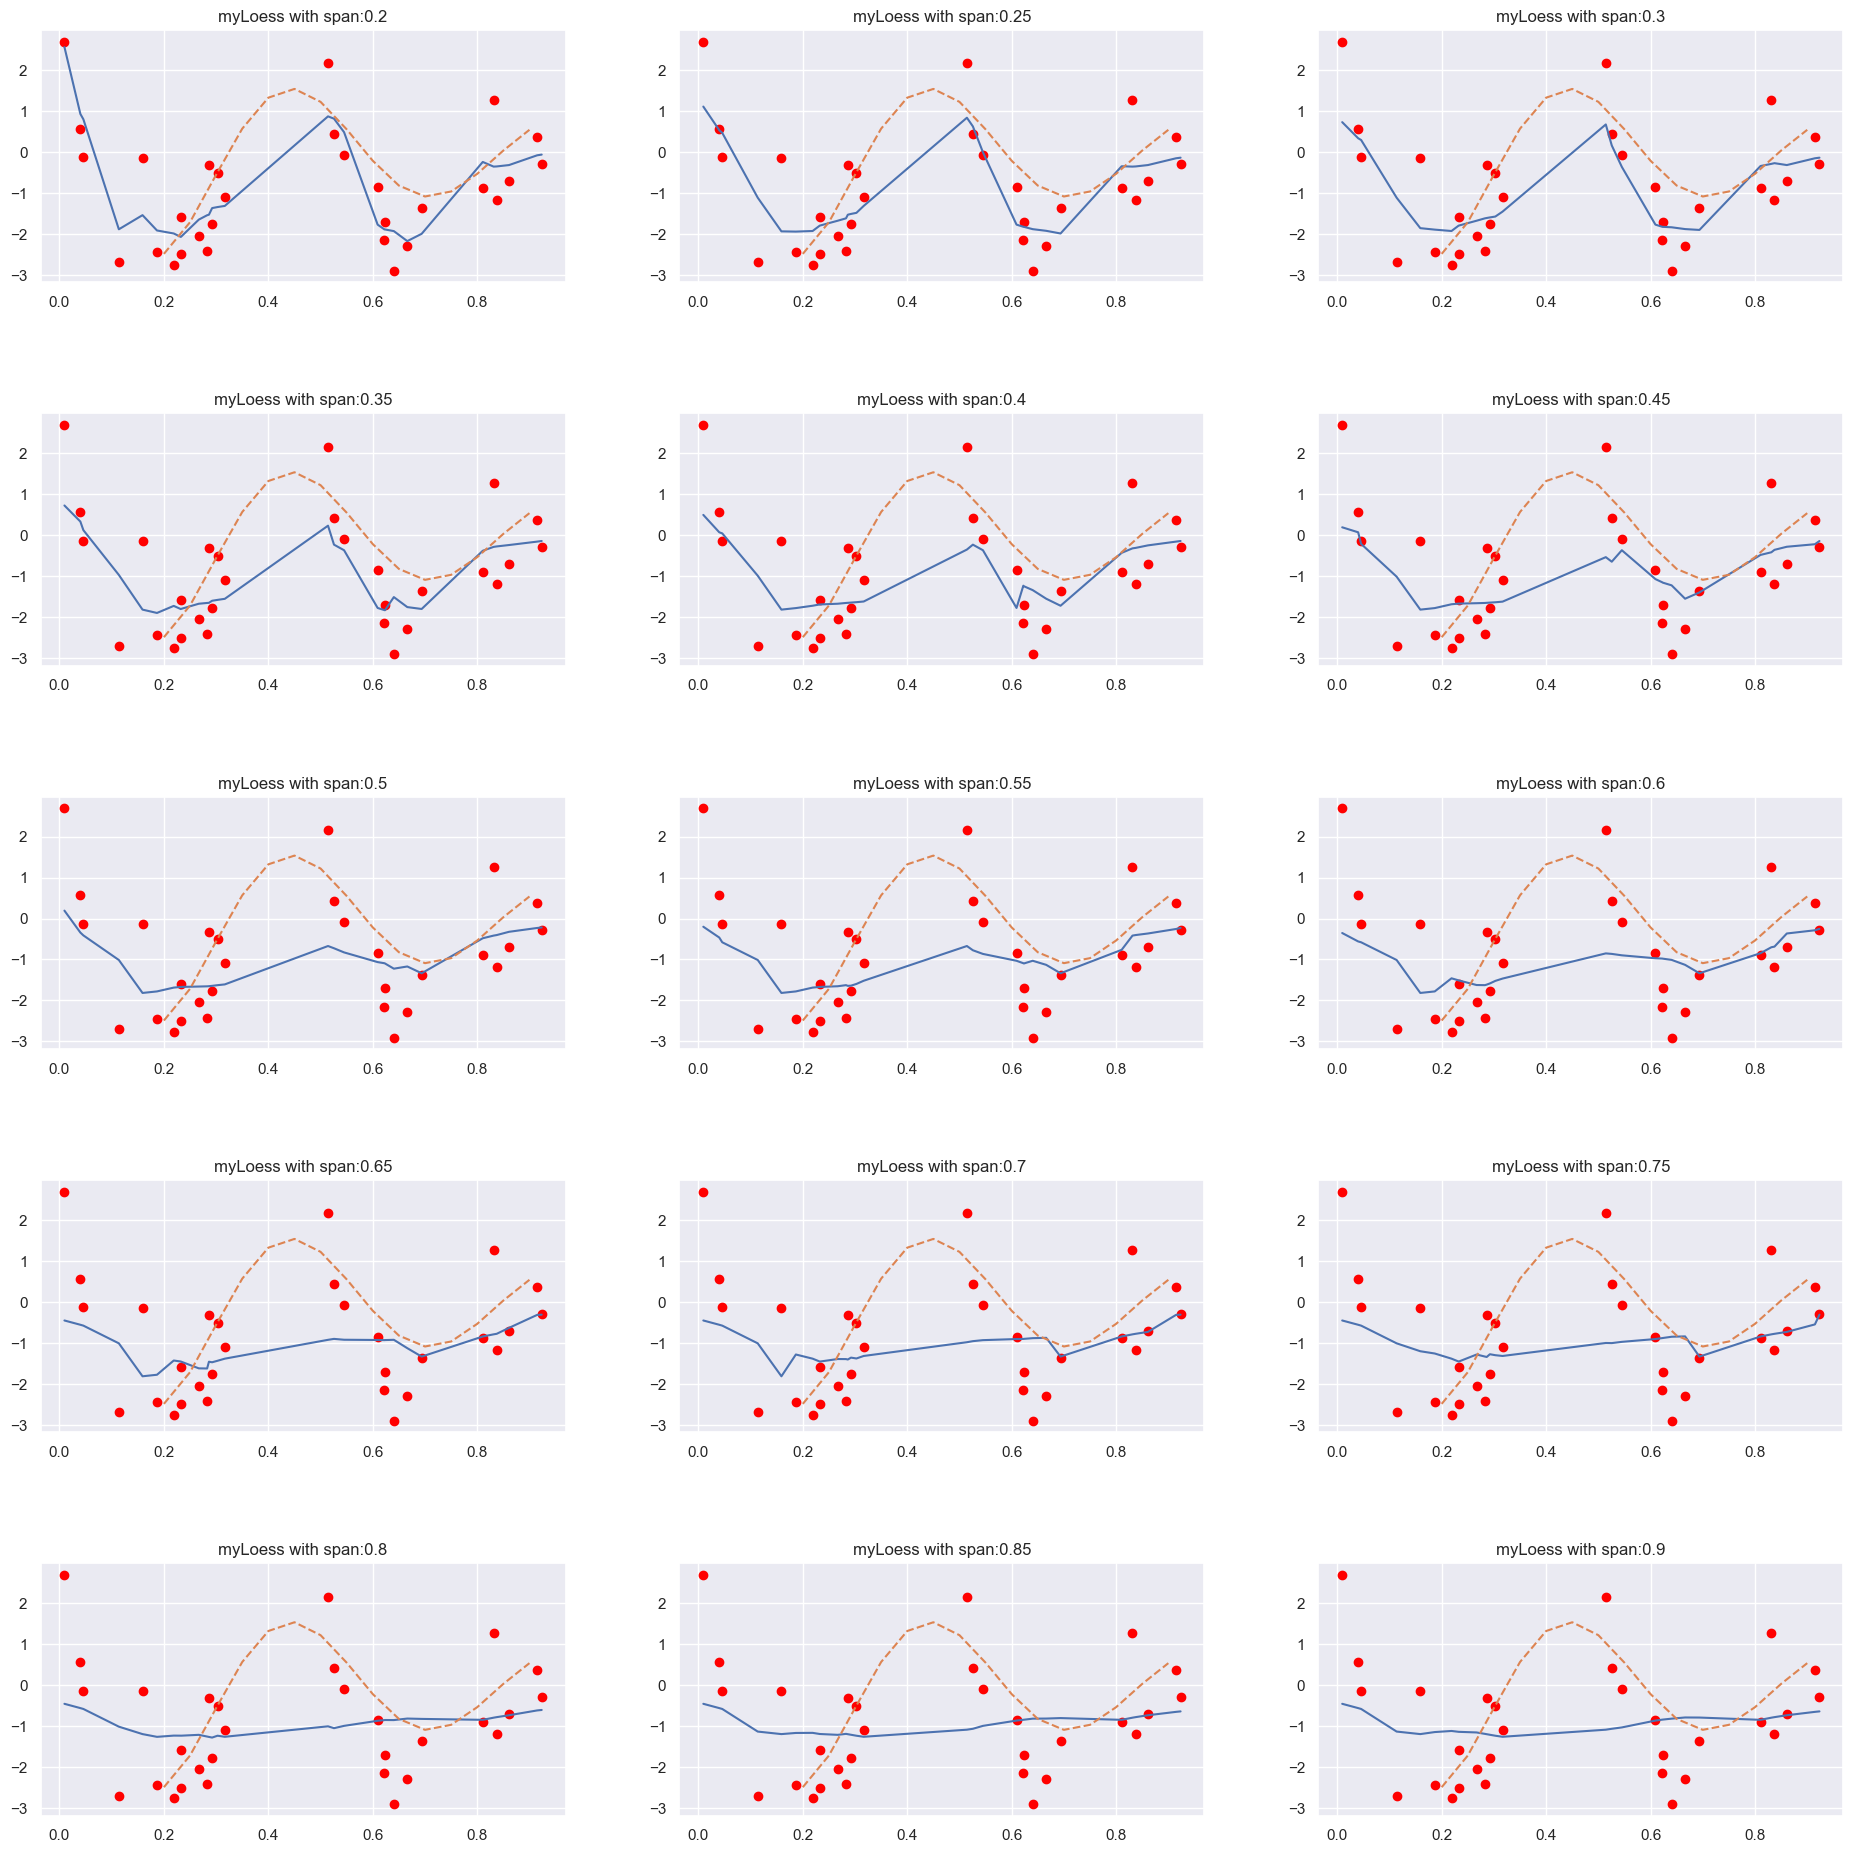

In [188]:
# Use code from PSL: Smoothing Splines
fig, axes  = plt.subplots(5,3, figsize=(20, 20))
z = 0
k = 0

def f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)
fx = np.arange(0.20, 0.95, 0.05)
fy = f(fx)
for i in np.arange(0.20, 0.95, 0.05):
    i = np.round(i,2)
    val = {}
    if z==3:
        k+=1
        z=0
    for j in df.x:
        xx = df.x[(df.x >= j -(i/2)) & \
                  (df.x <= j +(i/2))]
        yy = df.y[(df.x >= j -(i/2)) & \
                  (df.x <= j +(i/2))]
        l = myLoess(xx.tolist(), yy.tolist())
        y = l.eval_est(j, len(xx))
        val.update({j:y})      
    sns.set()    
    axes[k][z].plot(val.keys(), val.values())   
    axes[k][z].scatter(df.x, df.y, c='red')
    axes[k][z].plot(fx, fy, '--')
    axes[k][z].set_title(f'myLoess with span:{i}')
    fig.tight_layout(pad=5)
    z+=1
plt.show()

 Display the original data points and overlay them with the true curve and the fitted curve(s) generated using the optimal span value(s).

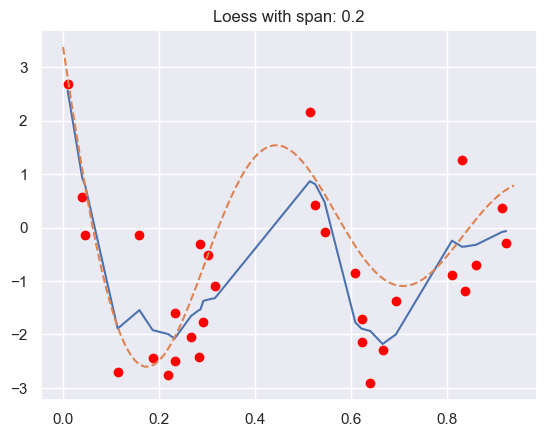

In [189]:
def f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)
fx = np.arange(0, 0.95, 0.01)
fy = f(fx)
i = 0.2
val = {}
for j in df.x:
    xx = df.x[(df.x >= j -(i/2)) & \
              (df.x <= j +(i/2))]
    yy = df.y[(df.x >= j -(i/2)) & \
              (df.x <= j +(i/2))]
    l = myLoess(xx.tolist(), yy.tolist())
    y = l.eval_est(j, len(xx))
    val.update({j:y})      

plt.plot(val.keys(), val.values())   
plt.scatter(df.x, df.y, c='red')
plt.plot(fx, fy, '--')
plt.title('Loess with span: 0.2')
plt.show()


Create a function to retrieve the diagonal of the smoother matrix.

In [190]:
def smootherm(x, a, b):
    xx = x[(x >= (b - (a/ 2))) & (x <=(b+ (a/2)))]
    y = np.zeros(len(xx))
    idx = xx.tolist().index(b)
    y[idx] = 1
    a = cr(xx, len(xx), constraints="center")
    trace = np.trace(a)
    ssum = np.sum(y.dot(a))
    return trace, ssum

In [191]:
smootherm(df.x, 0.20, df.x[2])


(1.3462491183023149, 0.20644296465770373)

In [195]:
def CV_GCV(i):
    val = {}
    for j in df.x:
        xx = df.x[(df.x >= j -(i/2)) & \
                  (df.x <= j +(i/2))]
        yy = df.y[(df.x >= j -(i/2)) & \
                  (df.x <= j +(i/2))]
        l = myLoess(xx.tolist(), yy.tolist())
        y = l.eval_est(j, len(xx))
        val.update({j:y})  
        
    CV = []
    GCV = []
    for k in df.x:
        trace, ssum = smootherm(df.x, i, k)
        CV_m = np.mean((np.subtract(list(val.values()), df.y.tolist())/(1-ssum))**2)
        CV.append(CV_m)
        GCV_m = np.mean((np.subtract(list(val.values()), df.y.tolist())/(1-trace/len(df.x)))**2)
        GCV.append(GCV_m)
    return np.mean(CV), np.mean(GCV)
# def GCV(i):
#     val = {}
#     for j in df.x:
#         xx = df.x[(df.x >= j -(i/2)) & \
#                   (df.x <= j +(i/2))]
#         yy = df.y[(df.x >= j -(i/2)) & \
#                   (df.x <= j +(i/2))]
#         l = myLoess(xx.tolist(), yy.tolist())
#         y = l.eval_est(j, len(xx))
#         val.update({j:y})  
#     GCV = []
#     for k in df.x:
#         trace, ssum = smootherm(df.x, i, k)
#         GCV_m = np.mean((np.subtract(list(val.values()), df.y.tolist())/(1-trace/len(df.x)))**2)
#         GCV.append(GCV_m)
#     return np.mean(CV), np.mean(GCV)

In [196]:
CV = [CV_GCV(i)[0] for i in np.arange(0.20, 0.95, 0.05)]
GCV = [CV_GCV(i)[1] for i in np.arange(0.20, 0.95, 0.05)]
data = {'CV':CV,
        'GCV': GCV,
        'span':  np.arange(0.20, 0.95, 0.05)}
result = pd.DataFrame(data)
result

,CV,GCV,span
0,7.094994,0.735851,0.20
1,3.326996,1.006344,0.25
2,3.338326,1.152951,0.30
3,2.385170,1.367912,0.35
4,3.092015,1.731826,0.40
5,3.041023,1.986886,0.45
6,3.645789,2.261569,0.50
7,3.733790,2.565587,0.55
8,4.286362,3.019136,0.60
9,4.307208,3.409849,0.65


In [197]:
print(result[result.CV == min(result.CV)])
print(result[result.GCV == min(result.GCV)])

        CV       GCV  span
3  2.38517  1.367912  0.35
         CV       GCV  span
0  7.094994  0.735851   0.2
